# Setting

In [ ]:
import copy
import random
from PIL import Image

import torch
import torch.nn as nn

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers.schedulers.scheduling_ddim import DDIMScheduler

class StableDiffuser(torch.nn.Module):
    def __init__(self):
        super().__init__()

        version = "CompVis/stable-diffusion-v1-4"
        self.vae = AutoencoderKL.from_pretrained(version, subfolder="vae")
        self.unet = UNet2DConditionModel.from_pretrained(version, subfolder="unet")
        self.scheduler = DDIMScheduler.from_pretrained(version, subfolder="scheduler")

        version = "openai/clip-vit-large-patch14"
        self.tokenizer = CLIPTokenizer.from_pretrained(version)
        self.text_encoder = CLIPTextModel.from_pretrained(version)

        self.eval()
    
    def get_embd(self, prompt):
        token = self.tokenizer(prompt, padding="max_length", return_tensors="pt").input_ids
        embd = self.text_encoder(token.to(self.unet.device))[0]

        token = self.tokenizer([""], padding="max_length", return_tensors="pt").input_ids
        uncond_embd = self.text_encoder(token.to(self.unet.device))[0]
    
        return torch.cat([uncond_embd, embd])
    
    def set_scheduler_timesteps(self, step):
        self.scheduler.set_timesteps(step, device=self.unet.device)

    def get_initial_latent(self):
        noise = torch.randn((1, 4, 64, 64), dtype=self.unet.dtype, device=self.unet.device)
        latent = noise * self.scheduler.init_noise_sigma
        return latent

    def predict_noise(self, iteration, latent, embd, guidance_scale=7.5):
        latent = torch.cat([latent] * 2)
        latent = self.scheduler.scale_model_input(latent, self.scheduler.timesteps[iteration])
        noise = self.unet(latent, self.scheduler.timesteps[iteration], encoder_hidden_states=embd).sample
        uncond_noise, noise = noise.chunk(2)
        noise = uncond_noise + guidance_scale * (noise - uncond_noise)
        return noise

    def diffusion(self, latent, embd, end_iteration, guidance_scale=7.5):
        for iteration in range(0, end_iteration):
            noise = self.predict_noise(iteration, latent, embd, guidance_scale)
            output = self.scheduler.step(noise, self.scheduler.timesteps[iteration], latent)
            latent = output.prev_sample
        return latent

    def decode(self, latent):
        return self.vae.decode(1 / self.vae.config.scaling_factor * latent).sample

    def to_image(self, image):
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        image = (image * 255).round().astype("uint8")
        return Image.fromarray(image[0])

    @torch.no_grad()
    def __call__(self, prompt):
        step = 50
        self.set_scheduler_timesteps(step)

        latent = self.get_initial_latent()
        embd = self.get_embd(prompt)

        latent = self.diffusion(latent, embd, step).to(self.unet.device)
        latent = self.decode(latent)
        image = self.to_image(latent)

        return image

def set_module(module, module_name, new_module):
    module_name = module_name.split('.')
    for name in module_name[:-1]:
        module = getattr(module, name)
    setattr(module, module_name[-1], new_module)

class FineTunedModel(nn.Module):
    def __init__(self, model):
        super().__init__()

        self.model = model
        for parameter in self.model.parameters(): parameter.requires_grad = False
        
        self.ft_modules = {}
        self.orig_modules = {}
        for name, module in diffuser.named_modules():
            if "attn2" not in name or module.__class__.__name__ != "Linear": continue
            ft_module = copy.deepcopy(module)
            self.orig_modules[name] = module
            self.ft_modules[name] = ft_module
            for parameter in ft_module.parameters(): parameter.requires_grad = True
        self.ft_modules_list = torch.nn.ModuleList(self.ft_modules.values())
        self.orig_modules_list = torch.nn.ModuleList(self.orig_modules.values())
    
    def __enter__(self):
        for key, ft_module in self.ft_modules.items():
            set_module(self.model, key, ft_module)
    
    def __exit__(self, exc_type, exc_value, tb):
        for key, module in self.orig_modules.items():
            set_module(self.model, key, module)

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\yoonj\anaconda3\Lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
    ^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'triton'


# Erase

In [ ]:
erase = ['Van Gogh']

device = "cuda"
diffuser = StableDiffuser().to(device)
diffuser.train()
finetuner = FineTunedModel(diffuser)
torch.cuda.empty_cache()

lr = 2e-05
optimizer = torch.optim.Adam(finetuner.parameters(), lr=lr)
criteria = nn.MSELoss()

# for i in range(200):
for i in range(50):
    with torch.no_grad():
        sampled_erase = erase[random.randint(0, len(erase)-1)]
        positive_embd = diffuser.get_embd([sampled_erase])
        neutral_embd = diffuser.get_embd([""])

        step = 50
        diffuser.set_scheduler_timesteps(step)
        iteration = random.randint(1, step-2)

        latent = diffuser.get_initial_latent()

        optimizer.zero_grad()

        with finetuner:
            latent = diffuser.diffusion(latent, positive_embd, iteration, 3.0)

        diffuser.set_scheduler_timesteps(1000)
        iteration = int(iteration / step * 1000)
        
        positive_latent = diffuser.predict_noise(iteration, latent, positive_embd, 1.0)
        neutral_latent = diffuser.predict_noise(iteration, latent, neutral_embd, 1.0)
    
    positive_latent.requires_grad = False
    neutral_latent.requires_grad = False
    
    with finetuner:
        negative_latent = diffuser.predict_noise(iteration, latent, positive_embd, 1.0)

    loss = criteria(negative_latent, neutral_latent - (positive_latent - neutral_latent))
    
    loss.backward()
    optimizer.step()

    print(f"Iteration {i:3d}: {loss.item():.3f}")

del optimizer, positive_embd, neutral_embd, latent, positive_latent, neutral_latent, negative_latent, loss
torch.cuda.empty_cache()

Iteration   0: 0.001
Iteration   1: 0.009
Iteration   2: 0.004
Iteration   3: 0.001
Iteration   4: 0.004
Iteration   5: 0.004
Iteration   6: 0.001
Iteration   7: 0.001
Iteration   8: 0.000
Iteration   9: 0.002
Iteration  10: 0.002
Iteration  11: 0.001
Iteration  12: 0.001
Iteration  13: 0.002
Iteration  14: 0.000
Iteration  15: 0.000
Iteration  16: 0.000
Iteration  17: 0.001
Iteration  18: 0.001
Iteration  19: 0.000
Iteration  20: 0.001
Iteration  21: 0.000
Iteration  22: 0.001
Iteration  23: 0.001
Iteration  24: 0.002
Iteration  25: 0.000
Iteration  26: 0.000
Iteration  27: 0.000
Iteration  28: 0.000
Iteration  29: 0.002
Iteration  30: 0.001
Iteration  31: 0.001
Iteration  32: 0.001
Iteration  33: 0.000
Iteration  34: 0.001
Iteration  35: 0.001
Iteration  36: 0.000
Iteration  37: 0.000
Iteration  38: 0.000
Iteration  39: 0.001
Iteration  40: 0.001
Iteration  41: 0.002
Iteration  42: 0.000
Iteration  43: 0.001
Iteration  44: 0.001
Iteration  45: 0.001
Iteration  46: 0.001
Iteration  47

# Inference

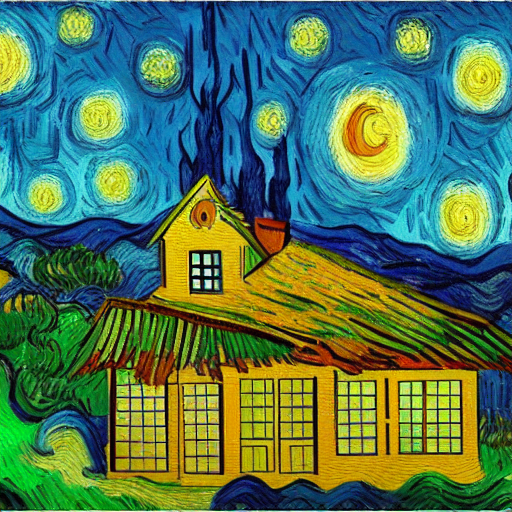

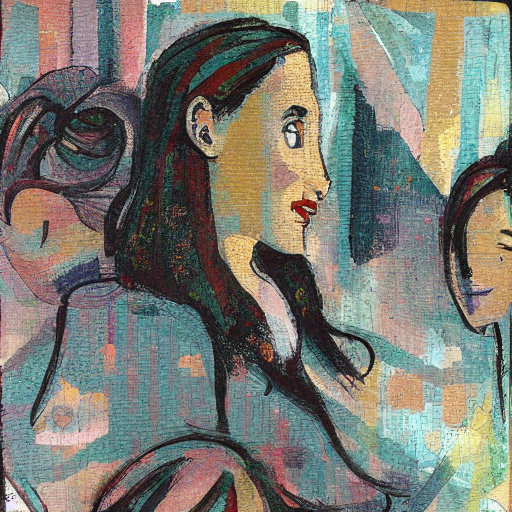

In [3]:
prompt = ['An image in the style of Vincent Van Gogh']
display(diffuser(prompt))
with finetuner:
    display(diffuser(prompt))

In [ ]:
del diffuser, finetuner
torch.cuda.empty_cache()